In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import xarray as xr
import numpy as np
import torch
import gpytorch
from gpytorch import means, kernels, likelihoods, distributions, lazy
import matplotlib.pyplot as plt
import tqdm

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.fair import forward
from src.fair.ancil import get_gas_params, get_thermal_params

<IPython.core.display.Javascript object>

In [3]:
# Load scenarios for training
inputs_ssp126 = xr.open_dataset('../data/inputs_ssp126.nc').compute()
inputs_ssp370 = xr.open_dataset('../data/inputs_ssp370.nc').compute()
inputs_ssp585 = xr.open_dataset('../data/inputs_ssp585.nc').compute()
inputs_histGHG = xr.open_dataset('../data/inputs_hist-GHG.nc').compute()
inputs_train = [inputs_ssp126, inputs_ssp370, inputs_ssp585, inputs_histGHG]

output_ssp126 = xr.open_dataset('../data/outputs_ssp126.nc').compute()
output_ssp370 = xr.open_dataset('../data/outputs_ssp370.nc').compute()
output_ssp585 = xr.open_dataset('../data/outputs_ssp585.nc').compute()
output_histGHG = xr.open_dataset('../data/outputs_hist-GHG.nc').compute()
outputs_train = [output_ssp126, output_ssp370, output_ssp585, output_histGHG]

# Load another one for testing
inputs_ssp245 = xr.open_dataset('../data/inputs_ssp245.nc').compute()
outputs_ssp245 = xr.open_dataset('../data/outputs_ssp245.nc').compute()


# Extrat CO2 and temperature anomaly arrays
def extract_arrays(xr_input, xr_output):
    time = xr_input.time.values
    cum_emissions = xr_input.CO2.values
    emissions = np.append(np.diff(cum_emissions)[0], np.diff(cum_emissions))
    weights = np.cos(np.deg2rad(xr_output.lat))
    tas = xr_output.tas.weighted(weights).mean(['lat', 'lon', 'member']).data
    return time, cum_emissions, emissions, tas

time_train = []
cum_emissions_train = []
emissions_train = []
tas_train = []
for xr_input, xr_output in zip(inputs_train, outputs_train):
    time, cum_emissions, emissions, tas = extract_arrays(xr_input, xr_output)
    time_train.append(time)
    cum_emissions_train.append(cum_emissions)
    emissions_train.append(emissions)
    tas_train.append(tas)
time_test, cum_emissions_test, emissions_test, tas_test = extract_arrays(inputs_ssp245, outputs_ssp245)

In [4]:
# Get CO2 gas parameters and thermal boxes parameters
gas_params_df = get_gas_params(['CO2'])
thermal_params_df = get_thermal_params()
gas_kwargs = gas_params_df.to_dict()['CO2']
d = thermal_params_df.T.d.values
q = thermal_params_df.T.q.values

base_kwargs = {'d': d,
               'q': q,
               **gas_kwargs}

In [5]:
# Run for training set
F_train = []
tas_fair_train = []
for time, emissions in zip(time_train, emissions_train):
    timestep = np.append(np.diff(time), np.diff(time)[-1])
    ext_forcing = np.zeros_like(time)
    run_kwargs = {'inp_ar': emissions.reshape(1, -1), 
                  'timestep': timestep,
                  'ext_forcing': ext_forcing,
                  **base_kwargs}
    res = forward.run(**run_kwargs)
    F_train.append(res['RF'].flatten())
    tas_fair_train.append(res['T'].flatten())

In [6]:
# Run for testing set
timestep = np.append(np.diff(time_test), np.diff(time_test)[-1])
ext_forcing = np.zeros_like(time_test)
run_kwargs_test = {'inp_ar': emissions_test.reshape(1, -1), 
                   'timestep': timestep,
                   'ext_forcing': ext_forcing,
                   **base_kwargs}
res_test = forward.run(**run_kwargs_test)

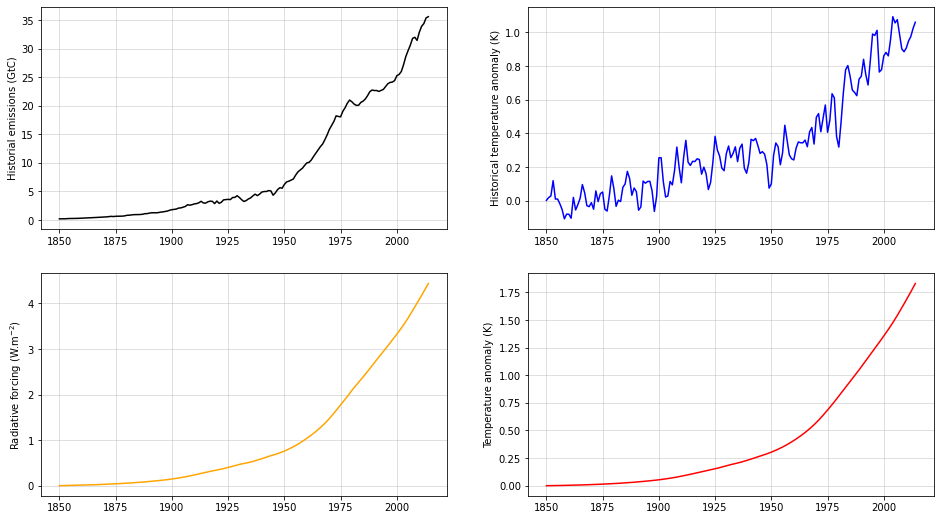

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

ax[0, 0].plot(time, emissions_train[3].flatten(), color='black')
ax[0, 0].set_ylabel('Historial emissions (GtC)')
ax[0, 0].grid(alpha=0.5)

ax[0, 1].plot(time, tas_train[3], color='blue')
ax[0, 1].set_ylabel('Historical temperature anomaly (K)')
ax[0, 1].grid(alpha=0.5)

ax[1, 0].plot(time, F_train[3], color='orange')
ax[1, 0].set_ylabel('Radiative forcing (W.m$^{-2}$)')
ax[1, 0].grid(alpha=0.5)

ax[1, 1].plot(time, tas_fair_train[3], color='red')
ax[1, 1].set_ylabel('Temperature anomaly (K)')
ax[1, 1].grid(alpha=0.5)
plt.show()

In [8]:
def get_ξ_from_forcing(q, d, F, dt=1):
    # Taken straight from FaIR codebase, not sure why computed this way
    ξ = q * (1 - np.exp(-dt / d)) * F
    return ξ

In [9]:
# Prepare tensors
Xtrain = torch.from_numpy(np.concatenate(cum_emissions_train)).float()
ytrain = torch.from_numpy(np.concatenate(tas_train)).float()
ξ_train = torch.from_numpy(get_ξ_from_forcing(q, d, np.concatenate(F_train).reshape(-1, 1)))

Xtest = torch.from_numpy(cum_emissions_test).float()
ytest = torch.from_numpy(tas_test).float()
ξ_test = torch.from_numpy(get_ξ_from_forcing(q, d, res_test['RF'].reshape(-1, 1)))

In [10]:
# Standardize inputs
mux, sigmax = Xtrain.mean(), Xtrain.std()
Xtrain_std = (Xtrain - mux) / sigmax
Xtest_std = (Xtest - mux) / sigmax

In [11]:
class ThermalBoxesGP(gpytorch.models.ExactGP):
    def __init__(self, X, y, means, kernels, d, ξ, likelihood):
        X = torch.cat([X.view(-1, 1), ξ], dim=-1)
        super(ThermalBoxesGP, self).__init__(X, y, likelihood)
        self.means = torch.nn.ModuleList(means)
        self.kernels = torch.nn.ModuleList(kernels)
        self.d = torch.from_numpy(d).float()
        self.ξ = ξ
        self.nboxes = len(d)

    def forward_box(self, x, idx):
        ξ = x[..., -self.nboxes:]
        x = x[..., :-self.nboxes]
        mean_box = torch.exp(-1. / self.d[idx]) * self.means[idx](x) + ξ[:, idx]
        covar_box = torch.exp(-2. / self.d[idx]) * self.kernels[idx](x)
        return mean_box, covar_box

    def forward(self, x):
        mean_x = []
        covar_x = []
        for idx in range(self.nboxes):
            mean_box, covar_box = self.forward_box(x, idx)
            mean_x.append(mean_box)
            covar_x.append(covar_box)
        mean_x = torch.stack(mean_x).sum(dim=0)
        covar_x = lazy.SumLazyTensor(*covar_x)
        return distributions.MultivariateNormal(mean_x, covar_x)

In [12]:
# Define thermal boxes GPs
m1 = means.ZeroMean()
m2 = means.ZeroMean()
m3 = means.ZeroMean()
k1 = kernels.RBFKernel()
k2 = kernels.RBFKernel()
k3 = kernels.RBFKernel()
likelihood = likelihoods.GaussianLikelihood()
model = ThermalBoxesGP(X=Xtrain_std, 
                       y=ytrain, 
                       means=[m1, m2, m3], 
                       kernels=[k1, k2, k3], 
                       d=d, 
                       ξ=ξ_train,
                       likelihood=likelihood)

In [13]:
# Find optimal model hyperparameters
model.train()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
n_iter = 200
training_iter = tqdm.notebook.tqdm(range(n_iter), desc='Iter')

for i in training_iter:
    optimizer.zero_grad()
    output = model(model.train_inputs[0])
    loss = -mll(output, ytrain)
    loss.backward()
    optimizer.step()
    training_iter.set_postfix_str(f"LL = {-loss.item()}")

In [14]:
model.eval()
with torch.no_grad():
    test_inputs = torch.cat([Xtest_std.view(-1, 1), ξ_test], dim=-1)
    pred = model(test_inputs)
    noisy_pred = model.likelihood(pred)

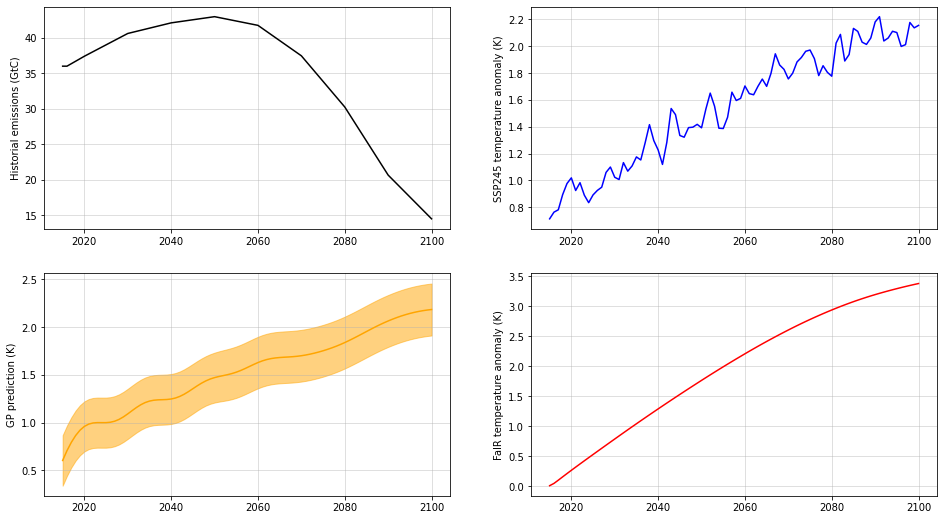

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

ax[0, 0].plot(time_test, emissions_test, color='black')
ax[0, 0].set_ylabel('Historial emissions (GtC)')
ax[0, 0].grid(alpha=0.5)

ax[0, 1].plot(time_test, tas_test, color='blue')
ax[0, 1].set_ylabel('SSP245 temperature anomaly (K)')
ax[0, 1].grid(alpha=0.5)

lb, ub = noisy_pred.confidence_region()
ax[1, 0].plot(time_test, pred.mean, color='orange')
ax[1, 0].fill_between(time_test, lb, ub, alpha=0.5, color='orange')
ax[1, 0].set_ylabel('GP prediction (K)')
ax[1, 0].grid(alpha=0.5)

ax[1, 1].plot(time_test, res_test['T'].flatten(), color='red')
ax[1, 1].set_ylabel('FaIR temperature anomaly (K)')
ax[1, 1].grid(alpha=0.5)
plt.show()

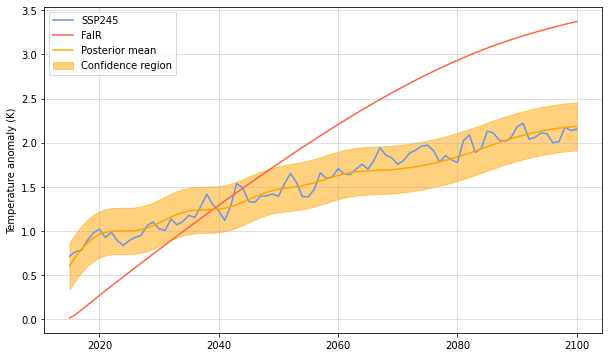

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

lb, ub = noisy_pred.confidence_region()

ax.plot(time_test, tas_test, color='cornflowerblue', label='SSP245')
ax.set_ylabel('Temperature anomaly (K)')
ax.plot(time_test, res_test['T'].flatten(), color='tomato', label='FaIR')
ax.plot(time_test, pred.mean, color='orange', label='Posterior mean')
ax.fill_between(time_test, lb, ub, alpha=0.5, color='orange', label='Confidence region')
ax.grid(alpha=0.5)
plt.legend()
plt.show()

In [18]:
rmse = torch.sqrt(torch.square(pred.mean - tas_test).mean()).item()
ll = noisy_pred.log_prob(torch.from_numpy(tas_test)).item()

print("RMSE = ", rmse)
print("LL = ", ll)

RMSE =  0.10364042832332936
LL =  72.20120241740777
